<sub>Developed by SeongKu Kang, August 2025 — Do not distribute</sub>

# 📘 Task 1: Product category classification (Fixed BERT embeddings)

In this notebook, we perform **product category classification** using **precomputed BERT mean-pooled embeddings**.  

Unlike the previous assignment where we used **TF-IDF features** as input to a linear classifier, here we replace TF-IDF with **semantic embeddings extracted from BERT**.  

---

### 🔎 Why BERT embeddings?
- **Context-aware**: BERT captures word meaning based on surrounding context, unlike bag-of-words TF-IDF.  
- **Better generalization**: Embeddings encode semantic similarity, making classification more robust to variations in wording.  

---

### ⚙️ Workflow
1. **Load precomputed embeddings** (saved earlier with mean pooling).  
2. **Prepare training and test datasets**.  
3. **Train a simple classifier** (linear layer or MLP) on top of BERT embeddings.  
4. **Evaluate performance** (accuracy, F1-macro).  

👉 The key difference from the TF-IDF baseline: **the input representation** (TF-IDF vs. BERT embeddings). 

---

### 🧪 Two training settings
In this notebook, we try two different setups:  

- **(A) Full-label training**: use all available labels (`pid2labelids_train`).  
- **(B) Limited-label training**: use a subset of labels (`pid2labelids_train_limited`).  

The limited-label scenario simulates a situation where fewer annotated examples are available,  
allowing us to compare model performance under different levels of supervision.  


In [1]:
import json
from tqdm import tqdm
from pathlib import Path
from utils import * 
import copy

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Default paths
ROOT = Path("dataset") # Root dataset directory
CORPUS_PATH = ROOT / "corpus.jsonl" # Product corpus file (JSON Lines): Each line contains a product ID and its associated text description.
EMB_PATH = ROOT / "corpus_bert_mean.pt"

# Task 1: Product category classification
LABEL_MAP_PATH = ROOT / "category_classification" 
LABEL2ID_PATH = LABEL_MAP_PATH / "label2labelid.json" 
ID2LABEL_PATH = LABEL_MAP_PATH / "labelid2label.json" 
PID2LABEL_TRAIN_PATH = LABEL_MAP_PATH / "pid2labelids_train.json"
PID2LABEL_TEST_PATH = LABEL_MAP_PATH / "pid2labelids_test.json" 

# === Load limited label training set (subset of pid2labelids_train) ===
PID2LABEL_TRAIN_LIMITED_PATH = LABEL_MAP_PATH / "pid2labelids_train_limited.json" 

In [3]:
pid2text = load_corpus(CORPUS_PATH) # load corpus

label2id = load_json(LABEL2ID_PATH)
id2label = load_json(ID2LABEL_PATH)
pid2label_train = load_json(PID2LABEL_TRAIN_PATH)
pid2label_test = load_json(PID2LABEL_TEST_PATH)

pid2label_train_limited = load_json(PID2LABEL_TRAIN_LIMITED_PATH)

# loading pre-trained embeddings
corpus_data = torch.load(EMB_PATH)  # {"ids": [...], "embeddings": Tensor}
pid_list = corpus_data["ids"]
pid2idx = {pid: i for i, pid in enumerate(pid_list)}
embeddings = corpus_data["embeddings"]

In [4]:
class ProductCategoryEmbeddingDataset(Dataset):
    def __init__(self, pid2label, pid2idx, embeddings):
        self.pids = list(pid2label.keys())
        self.labels = [pid2label[pid] for pid in self.pids]
        self.indices = [pid2idx[pid] for pid in self.pids]
        self.embeddings = embeddings

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        emb = self.embeddings[self.indices[idx]]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"X": emb, "y": label}

In [5]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device="cpu"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y = batch["y"].to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [6]:
import torch.nn as nn

class BaseClassifier(nn.Module):
    """
    A simple baseline classifier:
    - Input: precomputed embeddings (e.g., BERT mean-pooled vectors)
    - Output: logits over category classes
    """
    def __init__(self, input_dim, num_classes):
        super().__init__()
        # Linear layer: [batch_size, input_dim] -> [batch_size, num_classes]
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Returns raw logits (no softmax here, since loss function will handle it)
        return self.linear(x)

In [7]:
# Build test dataset and dataloader from precomputed embeddings
test_dataset = ProductCategoryEmbeddingDataset(pid2label_test, pid2idx, embeddings)
test_loader = DataLoader(test_dataset, batch_size=64)

# Model dimensions
input_dim = embeddings.shape[1]   # Size of embedding vector (feature dimension)
num_classes = len(label2id)       # Number of category classes

# Keep track of product IDs
all_pids = set(pid_list)
test_pids = set(pid2label_test.keys())

In [8]:
results_dict = {'valid':{}, 'test': {}}

## [Part A] training with default labeled set

In [9]:
# Build training dataset from embeddings
train_dataset = ProductCategoryEmbeddingDataset(pid2label_train, pid2idx, embeddings)

# Split into train/validation sets
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_split, val_split = random_split(train_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader = DataLoader(val_split, batch_size=64)

In [10]:
# Find products without labels
used_pids = set(pid2label_train.keys())
unlabeled_pids = all_pids - used_pids

# Ratio of unlabeled products in the whole corpus
unlabeled_ratio = len(unlabeled_pids) / len(all_pids)

print(f"[Unlabeled] {len(unlabeled_pids)} / {len(all_pids)} = {unlabeled_ratio:.2%}")

[Unlabeled] 26167 / 39452 = 66.33%


In [11]:
model = BaseClassifier(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [12]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)
        y = batch["y"].to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # === Validation ===
    val_result = evaluate(model, val_loader, device=device)
    val_acc = val_result["accuracy"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, test_loader, device=device)
    test_acc = test_result["accuracy"]
    test_acc_list.append(test_acc)
    print_eval_result(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1: 100%|██████████████████████████████████████████████| 333/333 [00:11<00:00, 30.16it/s]


[Epoch 1] Train Loss: 6.5034
[VAL ] Acc: 0.0467 | F1-macro: 0.0023 *
[TEST] Acc: 0.0544 | F1-macro: 0.0020


Epoch 2: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 240.93it/s]


[Epoch 2] Train Loss: 5.9223
[VAL ] Acc: 0.0749 | F1-macro: 0.0104 *
[TEST] Acc: 0.0885 | F1-macro: 0.0107


Epoch 3: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 242.98it/s]


[Epoch 3] Train Loss: 5.4938
[VAL ] Acc: 0.1174 | F1-macro: 0.0259 *
[TEST] Acc: 0.1262 | F1-macro: 0.0227


Epoch 4: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 244.59it/s]


[Epoch 4] Train Loss: 5.1082
[VAL ] Acc: 0.1539 | F1-macro: 0.0456 *
[TEST] Acc: 0.1619 | F1-macro: 0.0433


Epoch 5: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 220.88it/s]


[Epoch 5] Train Loss: 4.7645
[VAL ] Acc: 0.1919 | F1-macro: 0.0698 *
[TEST] Acc: 0.2062 | F1-macro: 0.0726


Epoch 6: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 213.80it/s]


[Epoch 6] Train Loss: 4.4569
[VAL ] Acc: 0.2326 | F1-macro: 0.0985 *
[TEST] Acc: 0.2430 | F1-macro: 0.0988


Epoch 7: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 235.50it/s]


[Epoch 7] Train Loss: 4.1725
[VAL ] Acc: 0.2582 | F1-macro: 0.1158 *
[TEST] Acc: 0.2703 | F1-macro: 0.1198


Epoch 8: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 212.26it/s]


[Epoch 8] Train Loss: 3.9191
[VAL ] Acc: 0.2887 | F1-macro: 0.1450 *
[TEST] Acc: 0.3058 | F1-macro: 0.1511


Epoch 9: 100%|█████████████████████████████████████████████| 333/333 [00:01<00:00, 249.64it/s]


[Epoch 9] Train Loss: 3.6868
[VAL ] Acc: 0.3207 | F1-macro: 0.1702 *
[TEST] Acc: 0.3345 | F1-macro: 0.1746


Epoch 10: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 247.50it/s]


[Epoch 10] Train Loss: 3.4768
[VAL ] Acc: 0.3429 | F1-macro: 0.1897 *
[TEST] Acc: 0.3625 | F1-macro: 0.2033


Epoch 11: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 244.81it/s]


[Epoch 11] Train Loss: 3.2823
[VAL ] Acc: 0.3715 | F1-macro: 0.2170 *
[TEST] Acc: 0.3873 | F1-macro: 0.2321


Epoch 12: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 223.17it/s]


[Epoch 12] Train Loss: 3.1027
[VAL ] Acc: 0.3918 | F1-macro: 0.2406 *
[TEST] Acc: 0.4212 | F1-macro: 0.2681


Epoch 13: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 213.44it/s]


[Epoch 13] Train Loss: 2.9364
[VAL ] Acc: 0.4178 | F1-macro: 0.2714 *
[TEST] Acc: 0.4374 | F1-macro: 0.2916


Epoch 14: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 232.96it/s]


[Epoch 14] Train Loss: 2.7833
[VAL ] Acc: 0.4449 | F1-macro: 0.3025 *
[TEST] Acc: 0.4621 | F1-macro: 0.3207


Epoch 15: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 208.31it/s]


[Epoch 15] Train Loss: 2.6400
[VAL ] Acc: 0.4592 | F1-macro: 0.3219 *
[TEST] Acc: 0.4813 | F1-macro: 0.3412


Epoch 16: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 243.75it/s]


[Epoch 16] Train Loss: 2.5109
[VAL ] Acc: 0.4753 | F1-macro: 0.3383 *
[TEST] Acc: 0.4923 | F1-macro: 0.3613


Epoch 17: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 247.36it/s]


[Epoch 17] Train Loss: 2.3858
[VAL ] Acc: 0.4912 | F1-macro: 0.3615 *
[TEST] Acc: 0.5104 | F1-macro: 0.3871


Epoch 18: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 242.19it/s]


[Epoch 18] Train Loss: 2.2716
[VAL ] Acc: 0.5017 | F1-macro: 0.3753 *
[TEST] Acc: 0.5276 | F1-macro: 0.4098


Epoch 19: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 224.67it/s]


[Epoch 19] Train Loss: 2.1625
[VAL ] Acc: 0.5183 | F1-macro: 0.3883 *
[TEST] Acc: 0.5397 | F1-macro: 0.4210


Epoch 20: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 215.41it/s]


[Epoch 20] Train Loss: 2.0655
[VAL ] Acc: 0.5262 | F1-macro: 0.4014 *
[TEST] Acc: 0.5510 | F1-macro: 0.4374


Epoch 21: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 233.13it/s]


[Epoch 21] Train Loss: 1.9709
[VAL ] Acc: 0.5337 | F1-macro: 0.4081 *
[TEST] Acc: 0.5630 | F1-macro: 0.4543


Epoch 22: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 212.93it/s]


[Epoch 22] Train Loss: 1.8852
[VAL ] Acc: 0.5446 | F1-macro: 0.4272 *
[TEST] Acc: 0.5689 | F1-macro: 0.4629


Epoch 23: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 415.58it/s]


[Epoch 23] Train Loss: 1.8020
[VAL ] Acc: 0.5559 | F1-macro: 0.4399 *
[TEST] Acc: 0.5707 | F1-macro: 0.4670


Epoch 24: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 478.43it/s]


[Epoch 24] Train Loss: 1.7246
[VAL ] Acc: 0.5638 | F1-macro: 0.4516 *
[TEST] Acc: 0.5824 | F1-macro: 0.4825


Epoch 25: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 504.13it/s]


[Epoch 25] Train Loss: 1.6524
[VAL ] Acc: 0.5747 | F1-macro: 0.4609 *
[TEST] Acc: 0.5869 | F1-macro: 0.4852


Epoch 26: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 468.53it/s]


[Epoch 26] Train Loss: 1.5866
[VAL ] Acc: 0.5770 | F1-macro: 0.4670 *
[TEST] Acc: 0.5928 | F1-macro: 0.4962


Epoch 27: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 469.51it/s]


[Epoch 27] Train Loss: 1.5206
[VAL ] Acc: 0.5864 | F1-macro: 0.4802 *
[TEST] Acc: 0.5982 | F1-macro: 0.5042


Epoch 28: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 334.15it/s]


[Epoch 28] Train Loss: 1.4591
[VAL ] Acc: 0.5909 | F1-macro: 0.4857 *
[TEST] Acc: 0.6118 | F1-macro: 0.5195


Epoch 29: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 462.54it/s]


[Epoch 29] Train Loss: 1.4050
[VAL ] Acc: 0.6037 | F1-macro: 0.4996 *
[TEST] Acc: 0.6177 | F1-macro: 0.5297


Epoch 30: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 476.94it/s]


[Epoch 30] Train Loss: 1.3504
[VAL ] Acc: 0.6090 | F1-macro: 0.5118 *
[TEST] Acc: 0.6210 | F1-macro: 0.5328


Epoch 31: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 463.93it/s]


[Epoch 31] Train Loss: 1.3003
[VAL ] Acc: 0.6161 | F1-macro: 0.5149 *
[TEST] Acc: 0.6269 | F1-macro: 0.5416


Epoch 32: 100%|████████████████████████████████████████████| 333/333 [00:00<00:00, 464.73it/s]


[Epoch 32] Train Loss: 1.2503
[VAL ] Acc: 0.6120 | F1-macro: 0.5167
[TEST] Acc: 0.6321 | F1-macro: 0.5534


Epoch 33: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 265.77it/s]


[Epoch 33] Train Loss: 1.2062
[VAL ] Acc: 0.6172 | F1-macro: 0.5216 *
[TEST] Acc: 0.6398 | F1-macro: 0.5557


Epoch 34: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 220.57it/s]


[Epoch 34] Train Loss: 1.1606
[VAL ] Acc: 0.6240 | F1-macro: 0.5282 *
[TEST] Acc: 0.6362 | F1-macro: 0.5538


Epoch 35: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 247.20it/s]


[Epoch 35] Train Loss: 1.1216
[VAL ] Acc: 0.6233 | F1-macro: 0.5291
[TEST] Acc: 0.6463 | F1-macro: 0.5658


Epoch 36: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 246.43it/s]


[Epoch 36] Train Loss: 1.0820
[VAL ] Acc: 0.6312 | F1-macro: 0.5363 *
[TEST] Acc: 0.6477 | F1-macro: 0.5701


Epoch 37: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 244.29it/s]


[Epoch 37] Train Loss: 1.0464
[VAL ] Acc: 0.6327 | F1-macro: 0.5398 *
[TEST] Acc: 0.6497 | F1-macro: 0.5747


Epoch 38: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 237.64it/s]


[Epoch 38] Train Loss: 1.0099
[VAL ] Acc: 0.6387 | F1-macro: 0.5487 *
[TEST] Acc: 0.6502 | F1-macro: 0.5792


Epoch 39: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 214.15it/s]


[Epoch 39] Train Loss: 0.9767
[VAL ] Acc: 0.6394 | F1-macro: 0.5501 *
[TEST] Acc: 0.6536 | F1-macro: 0.5813


Epoch 40: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 227.91it/s]


[Epoch 40] Train Loss: 0.9443
[VAL ] Acc: 0.6470 | F1-macro: 0.5593 *
[TEST] Acc: 0.6599 | F1-macro: 0.5851


Epoch 41: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 217.43it/s]


[Epoch 41] Train Loss: 0.9174
[VAL ] Acc: 0.6470 | F1-macro: 0.5616
[TEST] Acc: 0.6606 | F1-macro: 0.5869


Epoch 42: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 245.82it/s]


[Epoch 42] Train Loss: 0.8860
[VAL ] Acc: 0.6455 | F1-macro: 0.5595
[TEST] Acc: 0.6617 | F1-macro: 0.5921


Epoch 43: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 243.32it/s]


[Epoch 43] Train Loss: 0.8591
[VAL ] Acc: 0.6526 | F1-macro: 0.5706 *
[TEST] Acc: 0.6662 | F1-macro: 0.5979


Epoch 44: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 241.87it/s]


[Epoch 44] Train Loss: 0.8300
[VAL ] Acc: 0.6541 | F1-macro: 0.5683 *
[TEST] Acc: 0.6646 | F1-macro: 0.5955


Epoch 45: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 235.46it/s]


[Epoch 45] Train Loss: 0.8059
[VAL ] Acc: 0.6526 | F1-macro: 0.5704
[TEST] Acc: 0.6698 | F1-macro: 0.6014


Epoch 46: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 218.83it/s]


[Epoch 46] Train Loss: 0.7802
[VAL ] Acc: 0.6556 | F1-macro: 0.5712 *
[TEST] Acc: 0.6714 | F1-macro: 0.6055


Epoch 47: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 226.41it/s]


[Epoch 47] Train Loss: 0.7577
[VAL ] Acc: 0.6564 | F1-macro: 0.5768 *
[TEST] Acc: 0.6748 | F1-macro: 0.6088


Epoch 48: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 221.93it/s]


[Epoch 48] Train Loss: 0.7371
[VAL ] Acc: 0.6583 | F1-macro: 0.5770 *
[TEST] Acc: 0.6750 | F1-macro: 0.6073


Epoch 49: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 245.51it/s]


[Epoch 49] Train Loss: 0.7171
[VAL ] Acc: 0.6613 | F1-macro: 0.5834 *
[TEST] Acc: 0.6757 | F1-macro: 0.6126


Epoch 50: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 246.36it/s]


[Epoch 50] Train Loss: 0.6978
[VAL ] Acc: 0.6639 | F1-macro: 0.5851 *
[TEST] Acc: 0.6786 | F1-macro: 0.6137


Epoch 51: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 243.16it/s]


[Epoch 51] Train Loss: 0.6753
[VAL ] Acc: 0.6647 | F1-macro: 0.5859 *
[TEST] Acc: 0.6782 | F1-macro: 0.6169


Epoch 52: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 236.04it/s]


[Epoch 52] Train Loss: 0.6573
[VAL ] Acc: 0.6650 | F1-macro: 0.5812 *
[TEST] Acc: 0.6755 | F1-macro: 0.6147


Epoch 53: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 215.17it/s]


[Epoch 53] Train Loss: 0.6387
[VAL ] Acc: 0.6665 | F1-macro: 0.5853 *
[TEST] Acc: 0.6784 | F1-macro: 0.6157


Epoch 54: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 230.85it/s]


[Epoch 54] Train Loss: 0.6218
[VAL ] Acc: 0.6707 | F1-macro: 0.5902 *
[TEST] Acc: 0.6827 | F1-macro: 0.6223


Epoch 55: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 217.20it/s]


[Epoch 55] Train Loss: 0.6052
[VAL ] Acc: 0.6707 | F1-macro: 0.5891
[TEST] Acc: 0.6836 | F1-macro: 0.6218


Epoch 56: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 248.43it/s]


[Epoch 56] Train Loss: 0.5873
[VAL ] Acc: 0.6707 | F1-macro: 0.5902
[TEST] Acc: 0.6807 | F1-macro: 0.6220


Epoch 57: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 245.58it/s]


[Epoch 57] Train Loss: 0.5718
[VAL ] Acc: 0.6741 | F1-macro: 0.5928 *
[TEST] Acc: 0.6845 | F1-macro: 0.6243


Epoch 58: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 249.01it/s]


[Epoch 58] Train Loss: 0.5572
[VAL ] Acc: 0.6767 | F1-macro: 0.5949 *
[TEST] Acc: 0.6861 | F1-macro: 0.6275


Epoch 59: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 225.61it/s]


[Epoch 59] Train Loss: 0.5420
[VAL ] Acc: 0.6741 | F1-macro: 0.5936
[TEST] Acc: 0.6841 | F1-macro: 0.6220


Epoch 60: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 215.66it/s]


[Epoch 60] Train Loss: 0.5282
[VAL ] Acc: 0.6729 | F1-macro: 0.5946
[TEST] Acc: 0.6888 | F1-macro: 0.6319


Epoch 61: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 234.35it/s]


[Epoch 61] Train Loss: 0.5158
[VAL ] Acc: 0.6786 | F1-macro: 0.6033 *
[TEST] Acc: 0.6872 | F1-macro: 0.6303


Epoch 62: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 212.62it/s]


[Epoch 62] Train Loss: 0.5036
[VAL ] Acc: 0.6786 | F1-macro: 0.5952
[TEST] Acc: 0.6870 | F1-macro: 0.6275


Epoch 63: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 246.67it/s]


[Epoch 63] Train Loss: 0.4902
[VAL ] Acc: 0.6808 | F1-macro: 0.6055 *
[TEST] Acc: 0.6895 | F1-macro: 0.6307


Epoch 64: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 246.21it/s]


[Epoch 64] Train Loss: 0.4786
[VAL ] Acc: 0.6835 | F1-macro: 0.6026 *
[TEST] Acc: 0.6870 | F1-macro: 0.6279


Epoch 65: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 246.18it/s]


[Epoch 65] Train Loss: 0.4681
[VAL ] Acc: 0.6729 | F1-macro: 0.5971
[TEST] Acc: 0.6904 | F1-macro: 0.6339


Epoch 66: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 222.82it/s]


[Epoch 66] Train Loss: 0.4576
[VAL ] Acc: 0.6797 | F1-macro: 0.5990
[TEST] Acc: 0.6922 | F1-macro: 0.6364


Epoch 67: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 252.48it/s]


[Epoch 67] Train Loss: 0.4469
[VAL ] Acc: 0.6865 | F1-macro: 0.6067 *
[TEST] Acc: 0.6942 | F1-macro: 0.6353


Epoch 68: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 248.21it/s]


[Epoch 68] Train Loss: 0.4346
[VAL ] Acc: 0.6805 | F1-macro: 0.6016
[TEST] Acc: 0.6888 | F1-macro: 0.6338


Epoch 69: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 210.07it/s]


[Epoch 69] Train Loss: 0.4267
[VAL ] Acc: 0.6823 | F1-macro: 0.5995
[TEST] Acc: 0.6917 | F1-macro: 0.6358


Epoch 70: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 242.09it/s]


[Epoch 70] Train Loss: 0.4155
[VAL ] Acc: 0.6808 | F1-macro: 0.6032
[TEST] Acc: 0.6938 | F1-macro: 0.6391


Epoch 71: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 253.40it/s]


[Epoch 71] Train Loss: 0.4068
[VAL ] Acc: 0.6850 | F1-macro: 0.6071
[TEST] Acc: 0.6963 | F1-macro: 0.6419


Epoch 72: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 253.99it/s]


[Epoch 72] Train Loss: 0.3980
[VAL ] Acc: 0.6869 | F1-macro: 0.6069 *
[TEST] Acc: 0.6929 | F1-macro: 0.6381


Epoch 73: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 215.75it/s]


[Epoch 73] Train Loss: 0.3897
[VAL ] Acc: 0.6884 | F1-macro: 0.6109 *
[TEST] Acc: 0.6965 | F1-macro: 0.6444


Epoch 74: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 247.10it/s]


[Epoch 74] Train Loss: 0.3794
[VAL ] Acc: 0.6854 | F1-macro: 0.6076
[TEST] Acc: 0.6931 | F1-macro: 0.6399


Epoch 75: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 249.61it/s]


[Epoch 75] Train Loss: 0.3710
[VAL ] Acc: 0.6850 | F1-macro: 0.6075
[TEST] Acc: 0.6938 | F1-macro: 0.6408


Epoch 76: 100%|████████████████████████████████████████████| 333/333 [00:02<00:00, 163.79it/s]


[Epoch 76] Train Loss: 0.3631
[VAL ] Acc: 0.6861 | F1-macro: 0.6072
[TEST] Acc: 0.6942 | F1-macro: 0.6387


Epoch 77: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 284.57it/s]


[Epoch 77] Train Loss: 0.3550
[VAL ] Acc: 0.6880 | F1-macro: 0.6125
[TEST] Acc: 0.6953 | F1-macro: 0.6438


Epoch 78: 100%|████████████████████████████████████████████| 333/333 [00:01<00:00, 285.27it/s]


[Epoch 78] Train Loss: 0.3477
[VAL ] Acc: 0.6884 | F1-macro: 0.6125
[TEST] Acc: 0.6949 | F1-macro: 0.6420
[Early Stopping] No improvement for 5 consecutive epochs.


In [13]:
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, test_loader, device=device)
print_eval_result(final_test_result, stage="final_test")

results_dict['valid']['base_train'] = val_acc_list[:]
results_dict['test']['base_train'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.6949 | F1-macro: 0.6420


The approximate baseline performance for the default dataset is Acc: 0.6944 | F1-macro: 0.6442 | F1-micro: 0.6944

---
## [Part B] training with limited labeled set

The below dataset has less labels than the previous dataset.

In [14]:
# Build dataset with limited labeled products
train_dataset = ProductCategoryEmbeddingDataset(pid2label_train_limited, pid2idx, embeddings)

# Split into train/validation sets (80% / 20%)
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_split, val_split = random_split(train_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader = DataLoader(val_split, batch_size=64)

In [15]:
# Calculate how many products remain unlabeled under the limited training set
used_pids = set(pid2label_train_limited.keys())   # products with labels in the limited set
unlabeled_pids = all_pids - used_pids             # products without labels
unlabeled_ratio = len(unlabeled_pids) / len(all_pids)

print(f"[Unlabeled] {len(unlabeled_pids)} / {len(all_pids)} = {unlabeled_ratio:.2%}")

[Unlabeled] 32810 / 39452 = 83.16%


In [16]:
model = BaseClassifier(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [17]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)
        y = batch["y"].to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # === Validation ===
    val_result = evaluate(model, val_loader, device=device)
    val_acc = val_result["accuracy"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, test_loader, device=device)
    test_acc = test_result["accuracy"]
    test_acc_list.append(test_acc)
    print_eval_result(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 256.80it/s]


[Epoch 1] Train Loss: 6.6533
[VAL ] Acc: 0.0354 | F1-macro: 0.0026 *
[TEST] Acc: 0.0307 | F1-macro: 0.0013


Epoch 2: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 250.47it/s]


[Epoch 2] Train Loss: 6.2036
[VAL ] Acc: 0.0633 | F1-macro: 0.0072 *
[TEST] Acc: 0.0605 | F1-macro: 0.0043


Epoch 3: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 201.73it/s]


[Epoch 3] Train Loss: 5.9173
[VAL ] Acc: 0.0813 | F1-macro: 0.0121 *
[TEST] Acc: 0.0867 | F1-macro: 0.0091


Epoch 4: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 213.15it/s]


[Epoch 4] Train Loss: 5.6558
[VAL ] Acc: 0.0926 | F1-macro: 0.0138 *
[TEST] Acc: 0.1025 | F1-macro: 0.0126


Epoch 5: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 248.51it/s]


[Epoch 5] Train Loss: 5.4093
[VAL ] Acc: 0.1137 | F1-macro: 0.0236 *
[TEST] Acc: 0.1206 | F1-macro: 0.0191


Epoch 6: 100%|█████████████████████████████████████████████| 167/167 [00:01<00:00, 158.05it/s]


[Epoch 6] Train Loss: 5.1822
[VAL ] Acc: 0.1258 | F1-macro: 0.0308 *
[TEST] Acc: 0.1353 | F1-macro: 0.0280


Epoch 7: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 250.79it/s]


[Epoch 7] Train Loss: 4.9568
[VAL ] Acc: 0.1378 | F1-macro: 0.0397 *
[TEST] Acc: 0.1491 | F1-macro: 0.0355


Epoch 8: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 192.11it/s]


[Epoch 8] Train Loss: 4.7472
[VAL ] Acc: 0.1506 | F1-macro: 0.0503 *
[TEST] Acc: 0.1664 | F1-macro: 0.0463


Epoch 9: 100%|█████████████████████████████████████████████| 167/167 [00:00<00:00, 167.56it/s]


[Epoch 9] Train Loss: 4.5548
[VAL ] Acc: 0.1672 | F1-macro: 0.0608 *
[TEST] Acc: 0.1838 | F1-macro: 0.0605


Epoch 10: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.76it/s]


[Epoch 10] Train Loss: 4.3618
[VAL ] Acc: 0.1875 | F1-macro: 0.0761 *
[TEST] Acc: 0.2039 | F1-macro: 0.0772


Epoch 11: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.87it/s]


[Epoch 11] Train Loss: 4.1771
[VAL ] Acc: 0.2018 | F1-macro: 0.0840 *
[TEST] Acc: 0.2123 | F1-macro: 0.0837


Epoch 12: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.95it/s]


[Epoch 12] Train Loss: 4.0178
[VAL ] Acc: 0.2199 | F1-macro: 0.0983 *
[TEST] Acc: 0.2333 | F1-macro: 0.1021


Epoch 13: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 255.61it/s]


[Epoch 13] Train Loss: 3.8530
[VAL ] Acc: 0.2304 | F1-macro: 0.1053 *
[TEST] Acc: 0.2457 | F1-macro: 0.1124


Epoch 14: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.02it/s]


[Epoch 14] Train Loss: 3.7010
[VAL ] Acc: 0.2447 | F1-macro: 0.1186 *
[TEST] Acc: 0.2593 | F1-macro: 0.1214


Epoch 15: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.32it/s]


[Epoch 15] Train Loss: 3.5598
[VAL ] Acc: 0.2538 | F1-macro: 0.1247 *
[TEST] Acc: 0.2843 | F1-macro: 0.1416


Epoch 16: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 171.02it/s]


[Epoch 16] Train Loss: 3.4291
[VAL ] Acc: 0.2756 | F1-macro: 0.1428 *
[TEST] Acc: 0.2979 | F1-macro: 0.1553


Epoch 17: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.17it/s]


[Epoch 17] Train Loss: 3.2909
[VAL ] Acc: 0.2861 | F1-macro: 0.1585 *
[TEST] Acc: 0.3089 | F1-macro: 0.1701


Epoch 18: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 173.37it/s]


[Epoch 18] Train Loss: 3.1626
[VAL ] Acc: 0.3005 | F1-macro: 0.1718 *
[TEST] Acc: 0.3243 | F1-macro: 0.1834


Epoch 19: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.62it/s]


[Epoch 19] Train Loss: 3.0446
[VAL ] Acc: 0.3155 | F1-macro: 0.1862 *
[TEST] Acc: 0.3379 | F1-macro: 0.1993


Epoch 20: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 239.26it/s]


[Epoch 20] Train Loss: 2.9409
[VAL ] Acc: 0.3253 | F1-macro: 0.1969 *
[TEST] Acc: 0.3512 | F1-macro: 0.2119


Epoch 21: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 161.09it/s]


[Epoch 21] Train Loss: 2.8239
[VAL ] Acc: 0.3366 | F1-macro: 0.2050 *
[TEST] Acc: 0.3645 | F1-macro: 0.2267


Epoch 22: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 210.49it/s]


[Epoch 22] Train Loss: 2.7285
[VAL ] Acc: 0.3441 | F1-macro: 0.2172 *
[TEST] Acc: 0.3726 | F1-macro: 0.2351


Epoch 23: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.82it/s]


[Epoch 23] Train Loss: 2.6225
[VAL ] Acc: 0.3622 | F1-macro: 0.2359 *
[TEST] Acc: 0.3864 | F1-macro: 0.2542


Epoch 24: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.74it/s]


[Epoch 24] Train Loss: 2.5241
[VAL ] Acc: 0.3780 | F1-macro: 0.2482 *
[TEST] Acc: 0.3991 | F1-macro: 0.2630


Epoch 25: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.89it/s]


[Epoch 25] Train Loss: 2.4396
[VAL ] Acc: 0.3855 | F1-macro: 0.2526 *
[TEST] Acc: 0.4083 | F1-macro: 0.2767


Epoch 26: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.40it/s]


[Epoch 26] Train Loss: 2.3614
[VAL ] Acc: 0.3893 | F1-macro: 0.2599 *
[TEST] Acc: 0.4153 | F1-macro: 0.2846


Epoch 27: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 251.01it/s]


[Epoch 27] Train Loss: 2.2660
[VAL ] Acc: 0.3983 | F1-macro: 0.2695 *
[TEST] Acc: 0.4248 | F1-macro: 0.2991


Epoch 28: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 157.05it/s]


[Epoch 28] Train Loss: 2.1982
[VAL ] Acc: 0.4066 | F1-macro: 0.2724 *
[TEST] Acc: 0.4363 | F1-macro: 0.3095


Epoch 29: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.11it/s]


[Epoch 29] Train Loss: 2.1214
[VAL ] Acc: 0.4149 | F1-macro: 0.2845 *
[TEST] Acc: 0.4444 | F1-macro: 0.3221


Epoch 30: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 216.92it/s]


[Epoch 30] Train Loss: 2.0396
[VAL ] Acc: 0.4202 | F1-macro: 0.2858 *
[TEST] Acc: 0.4517 | F1-macro: 0.3284


Epoch 31: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 201.13it/s]


[Epoch 31] Train Loss: 1.9746
[VAL ] Acc: 0.4247 | F1-macro: 0.2936 *
[TEST] Acc: 0.4584 | F1-macro: 0.3366


Epoch 32: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.04it/s]


[Epoch 32] Train Loss: 1.9104
[VAL ] Acc: 0.4322 | F1-macro: 0.2990 *
[TEST] Acc: 0.4670 | F1-macro: 0.3449


Epoch 33: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 149.67it/s]


[Epoch 33] Train Loss: 1.8362
[VAL ] Acc: 0.4322 | F1-macro: 0.3030
[TEST] Acc: 0.4697 | F1-macro: 0.3530


Epoch 34: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 151.96it/s]


[Epoch 34] Train Loss: 1.7820
[VAL ] Acc: 0.4473 | F1-macro: 0.3140 *
[TEST] Acc: 0.4761 | F1-macro: 0.3590


Epoch 35: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 251.49it/s]


[Epoch 35] Train Loss: 1.7151
[VAL ] Acc: 0.4488 | F1-macro: 0.3180 *
[TEST] Acc: 0.4851 | F1-macro: 0.3689


Epoch 36: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.89it/s]


[Epoch 36] Train Loss: 1.6719
[VAL ] Acc: 0.4526 | F1-macro: 0.3210 *
[TEST] Acc: 0.4901 | F1-macro: 0.3747


Epoch 37: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.26it/s]


[Epoch 37] Train Loss: 1.6138
[VAL ] Acc: 0.4578 | F1-macro: 0.3279 *
[TEST] Acc: 0.4937 | F1-macro: 0.3782


Epoch 38: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.21it/s]


[Epoch 38] Train Loss: 1.5579
[VAL ] Acc: 0.4699 | F1-macro: 0.3357 *
[TEST] Acc: 0.4998 | F1-macro: 0.3865


Epoch 39: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 251.22it/s]


[Epoch 39] Train Loss: 1.5097
[VAL ] Acc: 0.4744 | F1-macro: 0.3466 *
[TEST] Acc: 0.5029 | F1-macro: 0.3911


Epoch 40: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.57it/s]


[Epoch 40] Train Loss: 1.4592
[VAL ] Acc: 0.4797 | F1-macro: 0.3551 *
[TEST] Acc: 0.5081 | F1-macro: 0.3974


Epoch 41: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 169.05it/s]


[Epoch 41] Train Loss: 1.4174
[VAL ] Acc: 0.4812 | F1-macro: 0.3564 *
[TEST] Acc: 0.5108 | F1-macro: 0.4009


Epoch 42: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 251.13it/s]


[Epoch 42] Train Loss: 1.3704
[VAL ] Acc: 0.4834 | F1-macro: 0.3577 *
[TEST] Acc: 0.5133 | F1-macro: 0.4017


Epoch 43: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 170.99it/s]


[Epoch 43] Train Loss: 1.3248
[VAL ] Acc: 0.4819 | F1-macro: 0.3534
[TEST] Acc: 0.5142 | F1-macro: 0.4009


Epoch 44: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.74it/s]


[Epoch 44] Train Loss: 1.2887
[VAL ] Acc: 0.4887 | F1-macro: 0.3637 *
[TEST] Acc: 0.5181 | F1-macro: 0.4092


Epoch 45: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 220.89it/s]


[Epoch 45] Train Loss: 1.2422
[VAL ] Acc: 0.4932 | F1-macro: 0.3663 *
[TEST] Acc: 0.5248 | F1-macro: 0.4173


Epoch 46: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 162.67it/s]


[Epoch 46] Train Loss: 1.2149
[VAL ] Acc: 0.5008 | F1-macro: 0.3727 *
[TEST] Acc: 0.5289 | F1-macro: 0.4234


Epoch 47: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 215.84it/s]


[Epoch 47] Train Loss: 1.1713
[VAL ] Acc: 0.4970 | F1-macro: 0.3711
[TEST] Acc: 0.5305 | F1-macro: 0.4293


Epoch 48: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.98it/s]


[Epoch 48] Train Loss: 1.1367
[VAL ] Acc: 0.5075 | F1-macro: 0.3825 *
[TEST] Acc: 0.5355 | F1-macro: 0.4314


Epoch 49: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.40it/s]


[Epoch 49] Train Loss: 1.0992
[VAL ] Acc: 0.5045 | F1-macro: 0.3763
[TEST] Acc: 0.5321 | F1-macro: 0.4302


Epoch 50: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 260.13it/s]


[Epoch 50] Train Loss: 1.0658
[VAL ] Acc: 0.5038 | F1-macro: 0.3793
[TEST] Acc: 0.5339 | F1-macro: 0.4337


Epoch 51: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.94it/s]


[Epoch 51] Train Loss: 1.0401
[VAL ] Acc: 0.5030 | F1-macro: 0.3794
[TEST] Acc: 0.5395 | F1-macro: 0.4390


Epoch 52: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.75it/s]


[Epoch 52] Train Loss: 1.0032
[VAL ] Acc: 0.5083 | F1-macro: 0.3818 *
[TEST] Acc: 0.5416 | F1-macro: 0.4415


Epoch 53: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 155.53it/s]


[Epoch 53] Train Loss: 0.9811
[VAL ] Acc: 0.5105 | F1-macro: 0.3837 *
[TEST] Acc: 0.5425 | F1-macro: 0.4411


Epoch 54: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.15it/s]


[Epoch 54] Train Loss: 0.9467
[VAL ] Acc: 0.5113 | F1-macro: 0.3827 *
[TEST] Acc: 0.5436 | F1-macro: 0.4442


Epoch 55: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 209.52it/s]


[Epoch 55] Train Loss: 0.9237
[VAL ] Acc: 0.5120 | F1-macro: 0.3848 *
[TEST] Acc: 0.5458 | F1-macro: 0.4468


Epoch 56: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 206.39it/s]


[Epoch 56] Train Loss: 0.8994
[VAL ] Acc: 0.5181 | F1-macro: 0.3932 *
[TEST] Acc: 0.5472 | F1-macro: 0.4508


Epoch 57: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.70it/s]


[Epoch 57] Train Loss: 0.8745
[VAL ] Acc: 0.5143 | F1-macro: 0.3895
[TEST] Acc: 0.5510 | F1-macro: 0.4538


Epoch 58: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 148.44it/s]


[Epoch 58] Train Loss: 0.8492
[VAL ] Acc: 0.5203 | F1-macro: 0.3918 *
[TEST] Acc: 0.5508 | F1-macro: 0.4540


Epoch 59: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 151.14it/s]


[Epoch 59] Train Loss: 0.8226
[VAL ] Acc: 0.5226 | F1-macro: 0.3958 *
[TEST] Acc: 0.5524 | F1-macro: 0.4555


Epoch 60: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.83it/s]


[Epoch 60] Train Loss: 0.8129
[VAL ] Acc: 0.5196 | F1-macro: 0.3974
[TEST] Acc: 0.5547 | F1-macro: 0.4594


Epoch 61: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.50it/s]


[Epoch 61] Train Loss: 0.7827
[VAL ] Acc: 0.5181 | F1-macro: 0.3911
[TEST] Acc: 0.5544 | F1-macro: 0.4589


Epoch 62: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.44it/s]


[Epoch 62] Train Loss: 0.7608
[VAL ] Acc: 0.5211 | F1-macro: 0.3963
[TEST] Acc: 0.5589 | F1-macro: 0.4634


Epoch 63: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.65it/s]


[Epoch 63] Train Loss: 0.7414
[VAL ] Acc: 0.5218 | F1-macro: 0.3969
[TEST] Acc: 0.5598 | F1-macro: 0.4651


Epoch 64: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.20it/s]


[Epoch 64] Train Loss: 0.7137
[VAL ] Acc: 0.5294 | F1-macro: 0.4053 *
[TEST] Acc: 0.5596 | F1-macro: 0.4626


Epoch 65: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.44it/s]


[Epoch 65] Train Loss: 0.6972
[VAL ] Acc: 0.5279 | F1-macro: 0.3999
[TEST] Acc: 0.5614 | F1-macro: 0.4676


Epoch 66: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 175.20it/s]


[Epoch 66] Train Loss: 0.6760
[VAL ] Acc: 0.5279 | F1-macro: 0.4034
[TEST] Acc: 0.5614 | F1-macro: 0.4681


Epoch 67: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.43it/s]


[Epoch 67] Train Loss: 0.6621
[VAL ] Acc: 0.5316 | F1-macro: 0.4084 *
[TEST] Acc: 0.5671 | F1-macro: 0.4726


Epoch 68: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 168.68it/s]


[Epoch 68] Train Loss: 0.6438
[VAL ] Acc: 0.5354 | F1-macro: 0.4095 *
[TEST] Acc: 0.5689 | F1-macro: 0.4755


Epoch 69: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.04it/s]


[Epoch 69] Train Loss: 0.6301
[VAL ] Acc: 0.5271 | F1-macro: 0.4044
[TEST] Acc: 0.5655 | F1-macro: 0.4735


Epoch 70: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 215.23it/s]


[Epoch 70] Train Loss: 0.6082
[VAL ] Acc: 0.5316 | F1-macro: 0.4076
[TEST] Acc: 0.5646 | F1-macro: 0.4737


Epoch 71: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 162.03it/s]


[Epoch 71] Train Loss: 0.5963
[VAL ] Acc: 0.5309 | F1-macro: 0.4058
[TEST] Acc: 0.5707 | F1-macro: 0.4779


Epoch 72: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 225.23it/s]


[Epoch 72] Train Loss: 0.5910
[VAL ] Acc: 0.5309 | F1-macro: 0.4065
[TEST] Acc: 0.5707 | F1-macro: 0.4794


Epoch 73: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 246.87it/s]


[Epoch 73] Train Loss: 0.5664
[VAL ] Acc: 0.5369 | F1-macro: 0.4148 *
[TEST] Acc: 0.5714 | F1-macro: 0.4807


Epoch 74: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 261.37it/s]


[Epoch 74] Train Loss: 0.5484
[VAL ] Acc: 0.5346 | F1-macro: 0.4117
[TEST] Acc: 0.5720 | F1-macro: 0.4820


Epoch 75: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 245.72it/s]


[Epoch 75] Train Loss: 0.5398
[VAL ] Acc: 0.5301 | F1-macro: 0.4058
[TEST] Acc: 0.5745 | F1-macro: 0.4818


Epoch 76: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.08it/s]


[Epoch 76] Train Loss: 0.5231
[VAL ] Acc: 0.5384 | F1-macro: 0.4138 *
[TEST] Acc: 0.5714 | F1-macro: 0.4799


Epoch 77: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.43it/s]


[Epoch 77] Train Loss: 0.5123
[VAL ] Acc: 0.5407 | F1-macro: 0.4130 *
[TEST] Acc: 0.5745 | F1-macro: 0.4861


Epoch 78: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 165.38it/s]


[Epoch 78] Train Loss: 0.4954
[VAL ] Acc: 0.5399 | F1-macro: 0.4138
[TEST] Acc: 0.5750 | F1-macro: 0.4869


Epoch 79: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.07it/s]


[Epoch 79] Train Loss: 0.4880
[VAL ] Acc: 0.5354 | F1-macro: 0.4170
[TEST] Acc: 0.5748 | F1-macro: 0.4854


Epoch 80: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 246.64it/s]


[Epoch 80] Train Loss: 0.4745
[VAL ] Acc: 0.5369 | F1-macro: 0.4165
[TEST] Acc: 0.5761 | F1-macro: 0.4874


Epoch 81: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 250.01it/s]


[Epoch 81] Train Loss: 0.4615
[VAL ] Acc: 0.5414 | F1-macro: 0.4192 *
[TEST] Acc: 0.5738 | F1-macro: 0.4863


Epoch 82: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.53it/s]


[Epoch 82] Train Loss: 0.4509
[VAL ] Acc: 0.5392 | F1-macro: 0.4168
[TEST] Acc: 0.5766 | F1-macro: 0.4882


Epoch 83: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.17it/s]


[Epoch 83] Train Loss: 0.4394
[VAL ] Acc: 0.5452 | F1-macro: 0.4214 *
[TEST] Acc: 0.5788 | F1-macro: 0.4900


Epoch 84: 100%|████████████████████████████████████████████| 167/167 [00:01<00:00, 164.84it/s]


[Epoch 84] Train Loss: 0.4278
[VAL ] Acc: 0.5444 | F1-macro: 0.4221
[TEST] Acc: 0.5788 | F1-macro: 0.4907


Epoch 85: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 192.74it/s]


[Epoch 85] Train Loss: 0.4213
[VAL ] Acc: 0.5452 | F1-macro: 0.4252
[TEST] Acc: 0.5788 | F1-macro: 0.4910


Epoch 86: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 258.36it/s]


[Epoch 86] Train Loss: 0.4113
[VAL ] Acc: 0.5444 | F1-macro: 0.4224
[TEST] Acc: 0.5784 | F1-macro: 0.4895


Epoch 87: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.84it/s]


[Epoch 87] Train Loss: 0.3981
[VAL ] Acc: 0.5474 | F1-macro: 0.4235 *
[TEST] Acc: 0.5802 | F1-macro: 0.4920


Epoch 88: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 248.98it/s]


[Epoch 88] Train Loss: 0.3889
[VAL ] Acc: 0.5497 | F1-macro: 0.4238 *
[TEST] Acc: 0.5799 | F1-macro: 0.4921


Epoch 89: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 247.79it/s]


[Epoch 89] Train Loss: 0.3835
[VAL ] Acc: 0.5467 | F1-macro: 0.4219
[TEST] Acc: 0.5802 | F1-macro: 0.4932


Epoch 90: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.55it/s]


[Epoch 90] Train Loss: 0.3717
[VAL ] Acc: 0.5459 | F1-macro: 0.4214
[TEST] Acc: 0.5829 | F1-macro: 0.4974


Epoch 91: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 212.94it/s]


[Epoch 91] Train Loss: 0.3654
[VAL ] Acc: 0.5452 | F1-macro: 0.4222
[TEST] Acc: 0.5822 | F1-macro: 0.4979


Epoch 92: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 203.61it/s]


[Epoch 92] Train Loss: 0.3560
[VAL ] Acc: 0.5467 | F1-macro: 0.4230
[TEST] Acc: 0.5808 | F1-macro: 0.4950


Epoch 93: 100%|████████████████████████████████████████████| 167/167 [00:00<00:00, 249.93it/s]


[Epoch 93] Train Loss: 0.3480
[VAL ] Acc: 0.5497 | F1-macro: 0.4289
[TEST] Acc: 0.5822 | F1-macro: 0.4983
[Early Stopping] No improvement for 5 consecutive epochs.


In [18]:
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, test_loader, device=device)
print_eval_result(final_test_result, stage="final_test")

results_dict['valid']['base_limited'] = val_acc_list[:]
results_dict['test']['base_limited'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.5822 | F1-macro: 0.4983


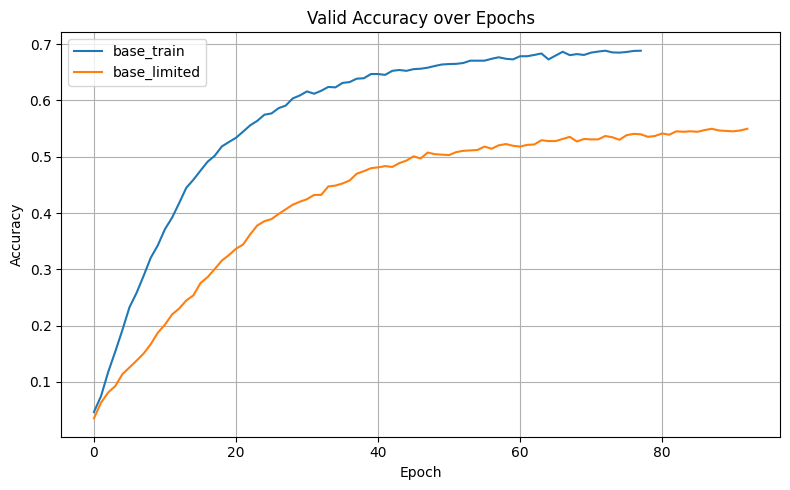

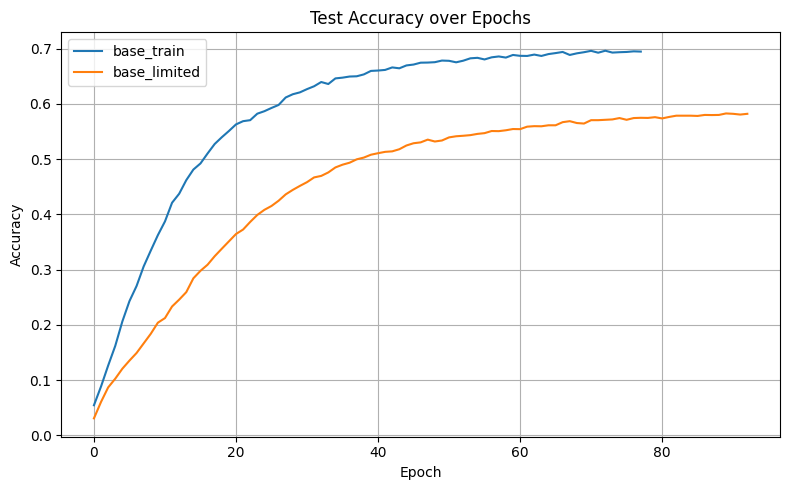

In [19]:
plot_results(results_dict, split="valid")
plot_results(results_dict, split="test")